In [1]:
import pandas as pd
data_path = "../duke-with-ELO.csv"
dataframe = pd.read_csv(data_path, header=0, index_col = 0)

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
%matplotlib inline

Using TensorFlow backend.


In [3]:
dataframe.shape

(500, 22)

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # data: Sequence of observations as a list or 2D NumPy array. Required.
    # n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
    #### window time series analysis: set n_in as 2, 3, ...
    # n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
    #### using past observations to forecast a sequence of future observations: multi-step, set n_in & n_out as 2, 3, ...
    # dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.
    #### Multi-variate forecasting: call this function on a dataframe as data
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data) 
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    #### Given a DataFrame, the shift() function can be used to create copies of columns 
    #### that are pushed forward (rows of NaN values added to the front) or pulled back 
    #### (rows of NaN values added to the end).
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    # return: Pandas DataFrame of series framed for supervised learning.
    return agg

In [5]:
values = dataframe.values
# encode wind_dir as integer
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
# coerce all data into float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0   0.100000   0.215190   0.000000        0.0        0.0   
2        0.0   0.113333   0.886076   0.000000        0.0        0.0   
3        0.0   0.146667   1.000000   0.836880        1.0        0.0   
4        0.0   0.166667   1.000000   0.514184        1.0        0.0   
5        0.0   0.193333   1.000000   0.336880        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var17(t-1)    ...     var13(t)  var14(t)  \
1   0.000000   0.348107   0.622869    0.762558    ...     0.761095  0.809629   
2   0.000000   0.348107   0.622869    0.762558    ...     0.761095  0.809629   
3   0.000000   0.348107   0.622869    0.762558    ...     0.761095  0.809629   
4   0.000000   0.348107   0.622869    0.762558    ...     0.770028  0.782116   
5   0.557143   0.510897   0.598957    0.637837    ...     0.875566  0.862848   

   var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  var21(t)  \
1  0.395529  0.51

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 450
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(450, 1, 36) (450,) (49, 1, 36) (49,)


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from matplotlib import pyplot as plt

Train on 450 samples, validate on 49 samples
Epoch 1/100
5s - loss: 0.6401 - acc: 0.6644 - val_loss: 0.6052 - val_acc: 0.6939
Epoch 2/100
3s - loss: 0.6168 - acc: 0.6667 - val_loss: 0.5841 - val_acc: 0.6939
Epoch 3/100
3s - loss: 0.5534 - acc: 0.6978 - val_loss: 0.5479 - val_acc: 0.6939
Epoch 4/100
4s - loss: 0.5284 - acc: 0.7311 - val_loss: 0.5210 - val_acc: 0.7347
Epoch 5/100
4s - loss: 0.4894 - acc: 0.7378 - val_loss: 0.5169 - val_acc: 0.7755
Epoch 6/100
4s - loss: 0.5033 - acc: 0.7556 - val_loss: 0.5017 - val_acc: 0.7755
Epoch 7/100
4s - loss: 0.4586 - acc: 0.7800 - val_loss: 0.4746 - val_acc: 0.8163
Epoch 8/100
4s - loss: 0.4631 - acc: 0.7933 - val_loss: 0.4659 - val_acc: 0.8163
Epoch 9/100
4s - loss: 0.4618 - acc: 0.7778 - val_loss: 0.4577 - val_acc: 0.8163
Epoch 10/100
4s - loss: 0.4595 - acc: 0.7756 - val_loss: 0.4438 - val_acc: 0.8163
Epoch 11/100
4s - loss: 0.4553 - acc: 0.7956 - val_loss: 0.4291 - val_acc: 0.8571
Epoch 12/100
4s - loss: 0.4360 - acc: 0.8000 - val_loss: 0.415

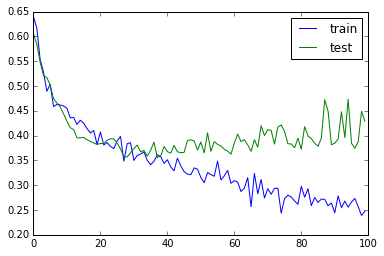

In [8]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
#### appears that two stacked LSTM layers overfit the model
model.add(Dropout(0.5))
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

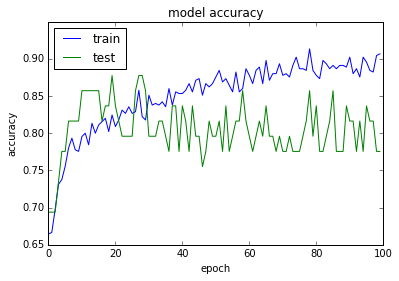

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
import numpy as np
# list all data in history
#print(history.history['val_acc'])
val_acc_array = np.array(history.history['val_acc'])
print("Average Accuracy: %.2f%%" % (np.mean(val_acc_array)*100))
print("Accuracy Standard Deviation: %.2f%%" % (np.std(val_acc_array)*100))

Average Accuracy: 80.55%
Accuracy Standard Deviation: 3.58%


In [12]:
# Final evaluation of the model
scores = model.evaluate(test_X, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 77.55%
